In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-08-09 18:47:14.955600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 18:47:16.885146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-09 18:47:18.410167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.451779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.452048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2023-08-09 18:47:18.467209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Default GPU Device: /device:GPU:0


2023-08-09 18:47:18.467806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.468185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.274752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-08-09 18:47:19.301960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.302476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.302783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [6]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

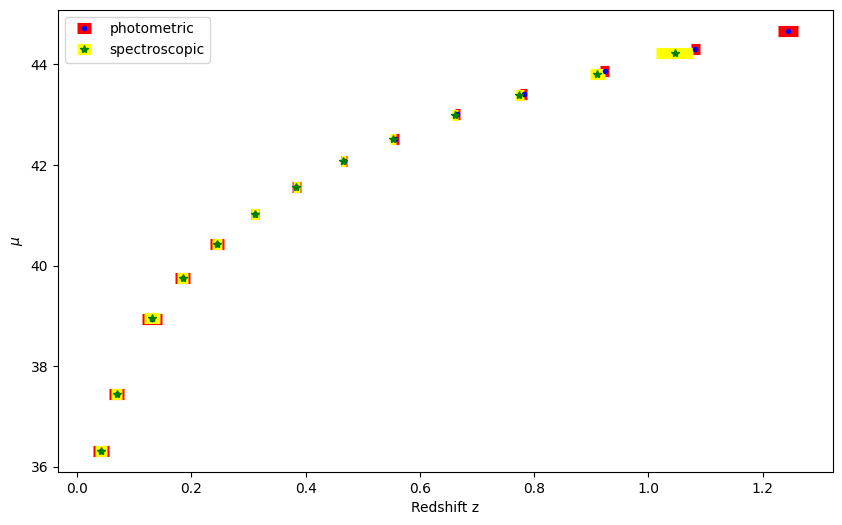

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [8]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [9]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [10]:
len(dfp)

14

In [11]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [12]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [13]:
np.shape(noise1y)

(14, 2)

In [14]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


In [15]:
np.shape(y), np.shape(z)

((42, 2), (42,))

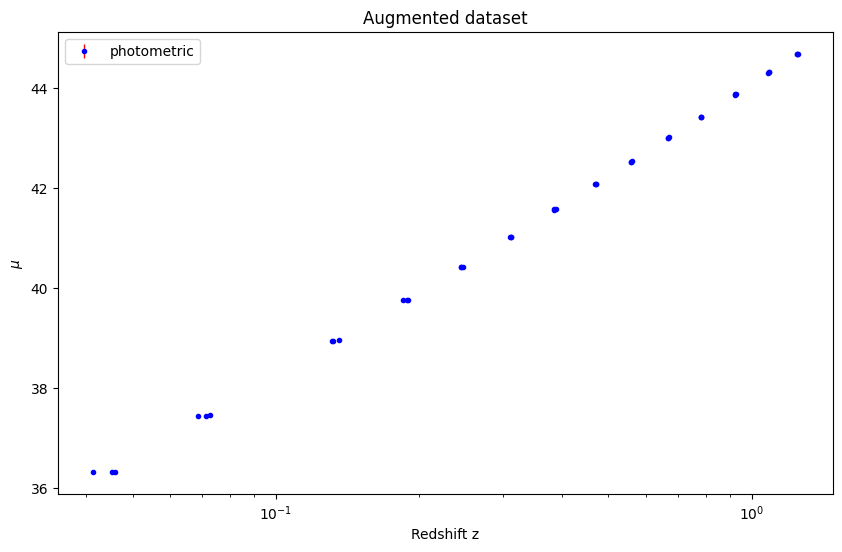

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [17]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z_sc = scalerz.transform(z.reshape(-1,1))
np.shape(z_sc)

(42, 1)

In [18]:
split = 0.9
ntrain = int(split * len(z))

randomize = np.random.permutation(len(z))
z = z_sc[randomize]
y = y[randomize]

indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

((37, 1), (5, 1), (37, 2), (5, 2))

In [19]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [20]:
yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]]))
np.shape(zz_train), np.shape(yy_train)

((39,), (39, 2))

In [27]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 8
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200,200,200,200])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               400       
                                                                 
 MCDropout_4 (MCDropout)     (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_5 (MCDropout)     (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_6 (MCDropout)     (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 200)              

In [33]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(zz_train, yy_train, batch_size=batch_size,
                                    epochs=2500, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2500
5/5 [==============================] - 1s 73ms/step - loss: 2.7198 - val_loss: 2.7581
Epoch 2/2500
5/5 [==============================] - 0s 20ms/step - loss: 4.7158 - val_loss: 1.8425
Epoch 3/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.4682 - val_loss: 1.2708
Epoch 4/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.3044 - val_loss: 1.5053
Epoch 5/2500
5/5 [==============================] - 0s 20ms/step - loss: 3.1589 - val_loss: 1.3047
Epoch 6/2500
5/5 [==============================] - 0s 17ms/step - loss: 4.8756 - val_loss: 1.4424
Epoch 7/2500
5/5 [==============================] - 0s 18ms/step - loss: 3.1956 - val_loss: 5.6489
Epoch 8/2500
5/5 [==============================] - 0s 19ms/step - loss: 2.3738 - val_loss: 1.9476
Epoch 9/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.4732 - val_loss: 2.4991
Epoch 10/2500
5/5 [==============================] - 0s 19ms/step - loss: 2.0660 - val_loss: 4.4155
Epoch 11/

5/5 [==============================] - 0s 15ms/step - loss: 3.3817 - val_loss: 2.2026
Epoch 84/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.2427 - val_loss: 3.9798
Epoch 85/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.5337 - val_loss: 6.1488
Epoch 86/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.6609 - val_loss: 2.1477
Epoch 87/2500
5/5 [==============================] - 0s 19ms/step - loss: 2.6132 - val_loss: 2.4977
Epoch 88/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.9295 - val_loss: 1.7953
Epoch 89/2500
5/5 [==============================] - 0s 15ms/step - loss: 3.9006 - val_loss: 3.2499
Epoch 90/2500
5/5 [==============================] - 0s 18ms/step - loss: 3.5517 - val_loss: 6.0087
Epoch 91/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.2092 - val_loss: 1.2984
Epoch 92/2500
5/5 [==============================] - 0s 15ms/step - loss: 3.4492 - val_loss: 3.9951
Epoch 93/2500


5/5 [==============================] - 0s 13ms/step - loss: 3.0139 - val_loss: 5.5071
Epoch 246/2500
5/5 [==============================] - 0s 12ms/step - loss: 3.4116 - val_loss: 5.5250
Epoch 247/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.3897 - val_loss: 4.3303
Epoch 248/2500
5/5 [==============================] - 0s 11ms/step - loss: 4.3856 - val_loss: 1.9902
Epoch 249/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.1030 - val_loss: 9.6160
Epoch 250/2500
5/5 [==============================] - 0s 12ms/step - loss: 3.2118 - val_loss: 1.5320
Epoch 251/2500
5/5 [==============================] - 0s 12ms/step - loss: 2.0249 - val_loss: 4.1213
Epoch 252/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.4088 - val_loss: 3.4946
Epoch 253/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.8968 - val_loss: 3.7363
Epoch 254/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.8597 - val_loss: 6.4623
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 2.9867 - val_loss: 0.3675
Epoch 408/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.4027 - val_loss: 1.6223
Epoch 409/2500
5/5 [==============================] - 0s 16ms/step - loss: 3.4985 - val_loss: 2.1675
Epoch 410/2500
5/5 [==============================] - 0s 18ms/step - loss: 3.5812 - val_loss: 3.3522
Epoch 411/2500
5/5 [==============================] - 0s 19ms/step - loss: 3.9517 - val_loss: 2.4289
Epoch 412/2500
5/5 [==============================] - 0s 20ms/step - loss: 2.3355 - val_loss: 2.1470
Epoch 413/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.6091 - val_loss: 1.3011
Epoch 414/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.4358 - val_loss: 2.1712
Epoch 415/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.4513 - val_loss: 1.8109
Epoch 416/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.5174 - val_loss: 3.7816
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 3.4102 - val_loss: 2.1016
Epoch 570/2500
5/5 [==============================] - 0s 12ms/step - loss: 2.8913 - val_loss: 4.6814
Epoch 571/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.1489 - val_loss: 1.7590
Epoch 572/2500
5/5 [==============================] - 0s 12ms/step - loss: 2.6340 - val_loss: 2.3499
Epoch 573/2500
5/5 [==============================] - 0s 11ms/step - loss: 1.9069 - val_loss: 1.6094
Epoch 574/2500
5/5 [==============================] - 0s 12ms/step - loss: 2.4522 - val_loss: 6.9745
Epoch 575/2500
5/5 [==============================] - 0s 12ms/step - loss: 2.6602 - val_loss: 1.9392
Epoch 576/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.6113 - val_loss: 5.9401
Epoch 577/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.4573 - val_loss: 2.6181
Epoch 578/2500
5/5 [==============================] - 0s 10ms/step - loss: 3.0400 - val_loss: 4.3025
Epoch

5/5 [==============================] - 0s 16ms/step - loss: 1.9461 - val_loss: 1.9801
Epoch 732/2500
5/5 [==============================] - 0s 19ms/step - loss: 2.6339 - val_loss: 0.8351
Epoch 733/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.0382 - val_loss: 2.4473
Epoch 734/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.8723 - val_loss: 1.3609
Epoch 735/2500
5/5 [==============================] - 0s 19ms/step - loss: 3.0033 - val_loss: 5.5552
Epoch 736/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.6841 - val_loss: 3.4465
Epoch 737/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.3328 - val_loss: 2.5402
Epoch 738/2500
5/5 [==============================] - 0s 14ms/step - loss: 1.8745 - val_loss: 1.6803
Epoch 739/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.9686 - val_loss: 3.7730
Epoch 740/2500
5/5 [==============================] - 0s 15ms/step - loss: 2.5087 - val_loss: 0.3941
Epoch

5/5 [==============================] - 0s 15ms/step - loss: 3.7458 - val_loss: 0.8622
Epoch 894/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.8822 - val_loss: 3.1152
Epoch 895/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.6405 - val_loss: 3.6747
Epoch 896/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.7942 - val_loss: 0.9338
Epoch 897/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.2623 - val_loss: 2.8330
Epoch 898/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.7121 - val_loss: 4.4042
Epoch 899/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.0334 - val_loss: 6.9431
Epoch 900/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.4087 - val_loss: 1.0428
Epoch 901/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.8897 - val_loss: 2.5932
Epoch 902/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.0644 - val_loss: 1.1112
Epoch

Epoch 1055/2500
5/5 [==============================] - 0s 7ms/step - loss: 2.3434 - val_loss: 2.4697
Epoch 1056/2500
5/5 [==============================] - 0s 8ms/step - loss: 2.3338 - val_loss: 3.2741
Epoch 1057/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.4744 - val_loss: 0.5232
Epoch 1058/2500
5/5 [==============================] - 0s 10ms/step - loss: 3.4251 - val_loss: 9.1610
Epoch 1059/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.7729 - val_loss: 2.4596
Epoch 1060/2500
5/5 [==============================] - 0s 10ms/step - loss: 1.9748 - val_loss: 8.1038
Epoch 1061/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.0512 - val_loss: 4.0427
Epoch 1062/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.8128 - val_loss: 2.2442
Epoch 1063/2500
5/5 [==============================] - 0s 10ms/step - loss: 2.2293 - val_loss: 2.7312
Epoch 1064/2500
5/5 [==============================] - 0s 11ms/step - loss: 1.8578 -

5/5 [==============================] - 0s 17ms/step - loss: 4.0268 - val_loss: 1.0789
Epoch 1216/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.3746 - val_loss: 2.5762
Epoch 1217/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.5335 - val_loss: 2.5466
Epoch 1218/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.0221 - val_loss: 1.7818
Epoch 1219/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.6333 - val_loss: 0.7661
Epoch 1220/2500
5/5 [==============================] - 0s 16ms/step - loss: 3.2354 - val_loss: 0.3843
Epoch 1221/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.7798 - val_loss: 5.0171
Epoch 1222/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.2635 - val_loss: 1.4726
Epoch 1223/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.7032 - val_loss: 5.5711
Epoch 1224/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.6614 - val_loss: 1.2

5/5 [==============================] - 0s 14ms/step - loss: 2.4546 - val_loss: 1.3047
Epoch 1376/2500
5/5 [==============================] - 0s 14ms/step - loss: 2.2945 - val_loss: 0.4326
Epoch 1377/2500
5/5 [==============================] - 0s 15ms/step - loss: 2.1384 - val_loss: 5.9655
Epoch 1378/2500
5/5 [==============================] - 0s 14ms/step - loss: 3.2673 - val_loss: 5.0528
Epoch 1379/2500
5/5 [==============================] - 0s 14ms/step - loss: 2.1118 - val_loss: 0.7138
Epoch 1380/2500
5/5 [==============================] - 0s 14ms/step - loss: 1.9200 - val_loss: 0.6491
Epoch 1381/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.0936 - val_loss: 0.4865
Epoch 1382/2500
5/5 [==============================] - 0s 10ms/step - loss: 2.1092 - val_loss: 1.6979
Epoch 1383/2500
5/5 [==============================] - 0s 9ms/step - loss: 1.8304 - val_loss: 2.6675
Epoch 1384/2500
5/5 [==============================] - 0s 10ms/step - loss: 1.9759 - val_loss: 1.24

5/5 [==============================] - 0s 16ms/step - loss: 1.7867 - val_loss: 1.2473
Epoch 1536/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.3358 - val_loss: 0.6062
Epoch 1537/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.2251 - val_loss: 0.7450
Epoch 1538/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.9900 - val_loss: 2.1636
Epoch 1539/2500
5/5 [==============================] - 0s 15ms/step - loss: 1.0761 - val_loss: 1.4446
Epoch 1540/2500
5/5 [==============================] - 0s 19ms/step - loss: 2.5453 - val_loss: 1.1264
Epoch 1541/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.8227 - val_loss: 1.2476
Epoch 1542/2500
5/5 [==============================] - 0s 15ms/step - loss: 2.1333 - val_loss: 2.4457
Epoch 1543/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.1627 - val_loss: 4.4761
Epoch 1544/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.3301 - val_loss: 2.7

5/5 [==============================] - 0s 12ms/step - loss: 2.2576 - val_loss: 3.5624
Epoch 1696/2500
5/5 [==============================] - 0s 11ms/step - loss: 2.7121 - val_loss: 0.2686
Epoch 1697/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.1115 - val_loss: 3.9386
Epoch 1698/2500
5/5 [==============================] - 0s 11ms/step - loss: 3.2630 - val_loss: 5.1647
Epoch 1699/2500
5/5 [==============================] - 0s 12ms/step - loss: 1.9192 - val_loss: 0.9746
Epoch 1700/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.3802 - val_loss: 5.1427
Epoch 1701/2500
5/5 [==============================] - 0s 15ms/step - loss: 2.4052 - val_loss: 0.8807
Epoch 1702/2500
5/5 [==============================] - 0s 20ms/step - loss: 2.5755 - val_loss: 2.3102
Epoch 1703/2500
5/5 [==============================] - 0s 21ms/step - loss: 2.2905 - val_loss: 3.5539
Epoch 1704/2500
5/5 [==============================] - 0s 21ms/step - loss: 3.0418 - val_loss: 3.7

5/5 [==============================] - 0s 16ms/step - loss: 1.7873 - val_loss: 2.5019
Epoch 1856/2500
5/5 [==============================] - 0s 16ms/step - loss: 3.4559 - val_loss: 1.5318
Epoch 1857/2500
5/5 [==============================] - 0s 14ms/step - loss: 2.4539 - val_loss: 1.9452
Epoch 1858/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.7690 - val_loss: 4.3657
Epoch 1859/2500
5/5 [==============================] - 0s 15ms/step - loss: 1.8942 - val_loss: 2.8609
Epoch 1860/2500
5/5 [==============================] - 0s 14ms/step - loss: 2.4242 - val_loss: 0.7967
Epoch 1861/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.3689 - val_loss: 3.7821
Epoch 1862/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.8110 - val_loss: 0.4789
Epoch 1863/2500
5/5 [==============================] - 0s 13ms/step - loss: 2.1189 - val_loss: 1.1967
Epoch 1864/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.1173 - val_loss: 1.8

5/5 [==============================] - 0s 16ms/step - loss: 2.4720 - val_loss: 1.0146
Epoch 2016/2500
5/5 [==============================] - 0s 9ms/step - loss: 2.1514 - val_loss: 3.2165
Epoch 2017/2500
5/5 [==============================] - 0s 7ms/step - loss: 3.2840 - val_loss: 1.1047
Epoch 2018/2500
5/5 [==============================] - 0s 10ms/step - loss: 1.1432 - val_loss: 1.7299
Epoch 2019/2500
5/5 [==============================] - 0s 11ms/step - loss: 1.9302 - val_loss: 1.5358
Epoch 2020/2500
5/5 [==============================] - 0s 10ms/step - loss: 1.7485 - val_loss: 1.7024
Epoch 2021/2500
5/5 [==============================] - 0s 10ms/step - loss: 2.7752 - val_loss: 0.7166
Epoch 2022/2500
5/5 [==============================] - 0s 10ms/step - loss: 2.7971 - val_loss: 0.8489
Epoch 2023/2500
5/5 [==============================] - 0s 10ms/step - loss: 1.8438 - val_loss: 6.9147
Epoch 2024/2500
5/5 [==============================] - 0s 12ms/step - loss: 3.2295 - val_loss: 0.607

5/5 [==============================] - 0s 16ms/step - loss: 1.8501 - val_loss: 3.6710
Epoch 2176/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.0287 - val_loss: 0.9407
Epoch 2177/2500
5/5 [==============================] - 0s 17ms/step - loss: 3.0543 - val_loss: 2.9499
Epoch 2178/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.2697 - val_loss: 3.6947
Epoch 2179/2500
5/5 [==============================] - 0s 18ms/step - loss: 1.6961 - val_loss: 1.0606
Epoch 2180/2500
5/5 [==============================] - 0s 15ms/step - loss: 1.7502 - val_loss: 2.3521
Epoch 2181/2500
5/5 [==============================] - 0s 18ms/step - loss: 1.8217 - val_loss: 4.7451
Epoch 2182/2500
5/5 [==============================] - 0s 15ms/step - loss: 2.0590 - val_loss: 6.2493
Epoch 2183/2500
5/5 [==============================] - 0s 17ms/step - loss: 1.6502 - val_loss: 2.8808
Epoch 2184/2500
5/5 [==============================] - 0s 15ms/step - loss: 1.7787 - val_loss: 3.0

5/5 [==============================] - 0s 16ms/step - loss: 1.9530 - val_loss: 2.5377
Epoch 2336/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.7504 - val_loss: 0.6714
Epoch 2337/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.0731 - val_loss: 2.1086
Epoch 2338/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.9479 - val_loss: 1.5699
Epoch 2339/2500
5/5 [==============================] - 0s 18ms/step - loss: 2.7636 - val_loss: 3.2246
Epoch 2340/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.7708 - val_loss: 1.2733
Epoch 2341/2500
5/5 [==============================] - 0s 16ms/step - loss: 1.4291 - val_loss: 3.6728
Epoch 2342/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.8217 - val_loss: 1.3093
Epoch 2343/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.0638 - val_loss: 1.0037
Epoch 2344/2500
5/5 [==============================] - 0s 17ms/step - loss: 2.7821 - val_loss: 2.6

5/5 [==============================] - 0s 15ms/step - loss: 1.7658 - val_loss: 2.5502
Epoch 2496/2500
5/5 [==============================] - 0s 14ms/step - loss: 1.4440 - val_loss: 2.4911
Epoch 2497/2500
5/5 [==============================] - 0s 13ms/step - loss: 1.6336 - val_loss: 1.3238
Epoch 2498/2500
5/5 [==============================] - 0s 16ms/step - loss: 2.3107 - val_loss: 1.5762
Epoch 2499/2500
5/5 [==============================] - 0s 12ms/step - loss: 1.6317 - val_loss: 3.1900
Epoch 2500/2500
5/5 [==============================] - 0s 14ms/step - loss: 2.3770 - val_loss: 1.8011


In [34]:
model_train.history['val_loss'][-1]

1.8011497259140015

(0.0, 200.0)

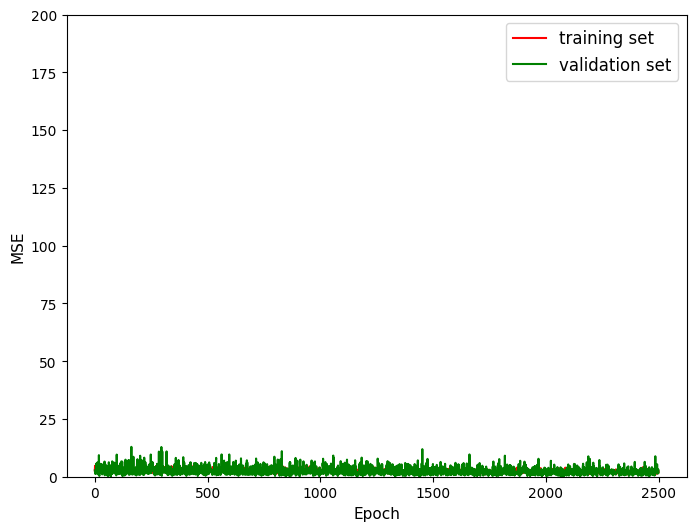

In [35]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [36]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


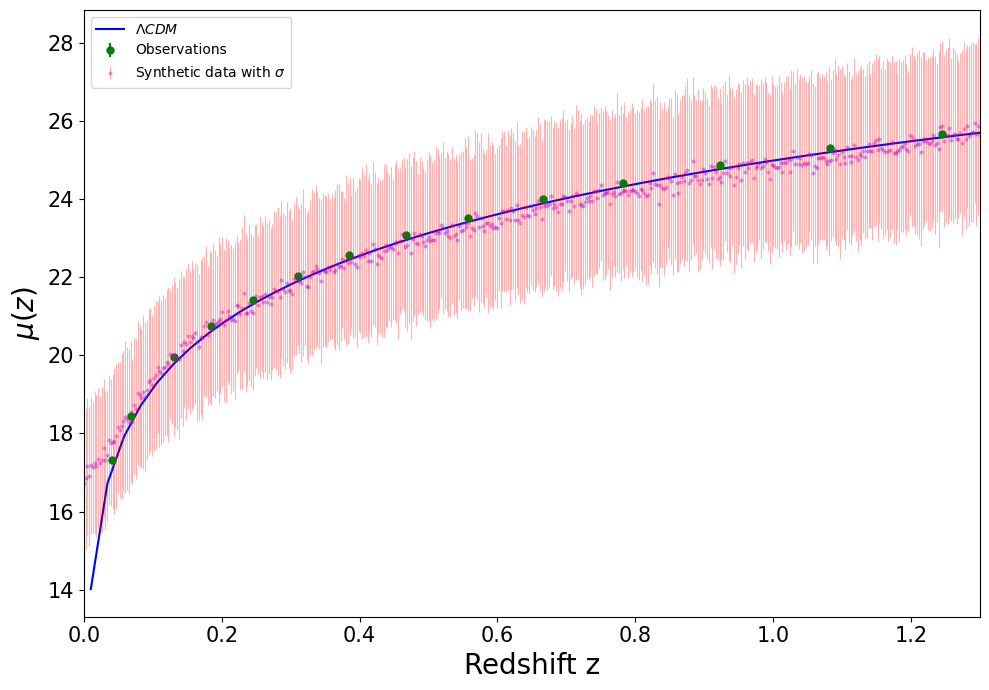

In [38]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig('firs_model.png', dpi=100)
# zCMB 	MU 	errors